<a href="https://colab.research.google.com/github/databyhuseyn/MachineLearning/blob/main/MNIST_Simple_ML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X_train = mnist.data[:50_000]
X_test = mnist.data[60_000:]

X_validation = mnist.data[50_000:60_000]
y_validation = mnist.target[50_000:60_000]

y_train = mnist.target[:50_000]
y_test = mnist.target[60_000:]

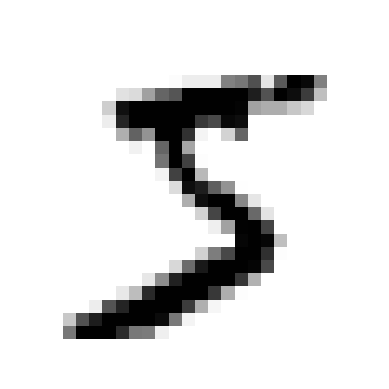

In [ ]:
def digit_image(num_image):
  num_image_reshaped = num_image.reshape(28, 28)
  plt.imshow(num_image_reshaped, cmap = 'binary')
  plt.axis('off')

digit_image(X_train[0])

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('rfc', RandomForestClassifier(random_state=42)),
        ('exTree', ExtraTreesClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)




In [ ]:
voting_clf.fit(X_train[:10_000], y_train[:10_000])            # since it takes too long, we should use first 10k data

VotingClassifier(estimators=[('rfc', RandomForestClassifier(random_state=42)),
                             ('exTree', ExtraTreesClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [ ]:
voting_clf.named_estimators_

{'rfc': RandomForestClassifier(random_state=42),
 'exTree': ExtraTreesClassifier(random_state=42),
 'svc': SVC(random_state=42)}

In [ ]:
rfc1 = RandomForestClassifier(random_state=42).fit(X_train[:10_000], y_train[:10_000])
etc1 = ExtraTreesClassifier(random_state=42).fit(X_train[:10_000], y_train[:10_000])
svc1 = SVC(random_state=42, probability=True).fit(X_train[:10_000], y_train[:10_000])

rfc1.score(X_validation, y_validation), etc1.score(X_validation, y_validation) ,svc1.score(X_validation, y_validation)

(0.9521, 0.9598, 0.966)

In [ ]:
voting_clf.score(X_validation, y_validation)

0.9613

In [ ]:
voting_clf.named_estimators

{'rfc': RandomForestClassifier(random_state=42),
 'exTree': ExtraTreesClassifier(random_state=42),
 'svc': SVC(random_state=42)}

In [ ]:
voting_clf.named_estimators_

{'rfc': RandomForestClassifier(random_state=42),
 'exTree': ExtraTreesClassifier(random_state=42),
 'svc': SVC(random_state=42)}

In [ ]:
for name, clf in voting_clf.named_estimators_.items():
  clf.fit(X_train, y_train)
  print(name, '=', clf.score(X_validation, y_validation))


rfc = 0.9736
exTree = 0.9743
svc = 0.9802


In [ ]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability=True
voting_clf.fit(X_train[:10_000], y_train[:10_000])

VotingClassifier(estimators=[('rfc', RandomForestClassifier(random_state=42)),
                             ('exTree', ExtraTreesClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
voting_clf.score(X_validation, y_validation)

0.9662

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

In [ ]:
predictions = voting_clf.predict(X_validation)

In [ ]:
f1_score(predictions, y_test, average='macro'), recall_score(predictions, y_test, average='macro'), precision_score(predictions, y_test, average='macro')

(0.10164670979274917, 0.10165482713973613, 0.10171554101984312)

# Part 2

In [ ]:
rfc_pred = rfc1.predict(X_validation)
etc_pred = etc1.predict(X_validation)
svc_pred = svc1.predict(X_validation)


data = pd.concat([pd.DataFrame(rfc_pred) , pd.DataFrame(etc_pred) ,pd.DataFrame(svc_pred)], axis=1)

data

,0,0,0
0,3,3,3
1,8,8,8
2,6,6,6
3,9,9,9
4,6,6,6
...,...,...,...
9995,8,8,8
9996,3,3,3
9997,5,5,5
9998,6,6,6


In [ ]:
rfc2 = RandomForestClassifier(random_state=43)

rfc2.fit(data, y_validation)

RandomForestClassifier(random_state=43)

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(data, y_validation, test_size=0.2)

rfc2.oob_score_

In [ ]:
rfc2.score(X_test1, y_test1)

0.976

# Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('rfc', RandomForestClassifier(random_state=42)),
        ('exTree', ExtraTreesClassifier(random_state=42)),
        ('svc', SVC(random_state=42, probability=True))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5      # number of cross-validation folds
)

stacking_clf.fit(X_train[:10_000], y_train[:10_000])

StackingClassifier(cv=5,
                   estimators=[('rfc', RandomForestClassifier(random_state=42)),
                               ('exTree',
                                ExtraTreesClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [ ]:
stacking_clf.score(X_test, y_test)

0.964